In [37]:
%matplotlib inline
from simulation import *
from math import *
import numpy as np

wavelength = 1
NA = 1
pitch = 10
# dx = 0.1
dx = 0.25
dbu = 1e-6
size = int(ceil(pitch / dx))
grid_info_2d = grid_info_2d_s.create_grid_info_bloch_mode([size, size], wavelength, 0.0, NA, [[-pitch/2, -pitch/2], [pitch/2, pitch/2]], dbu)
xsize, ysize = grid_info_2d.tilesize


In [38]:
print(grid_info_2d)

* grid info                   
--------------------------------
tilesize      :  [40,40]      
spatial start :  [-5,-5]      
spatial step  :  [0.25,0.25]  
fourier start :  [0,0]        
fourier step  :  [0.1,0.1]    
coords place  :  |*--|corner  



In [39]:
def to_dbu(n):
    return int(n/dbu)
def from_dbu(n):
    return n *dbu

mat_metal = material_eps(); 
mat_metal.name = "Metal"
mat_metal.set_scalar(1+0j)
mat_air = material_eps(); 
mat_air.name = "Air"
mat_air.set_scalar(0+0j)

pattern = geometry_pattern()
pattern.pBackground = mat_air
pattern.dbu = dbu
pattern.name = "test"

s1 = shape(); 
s1.pMaterial = mat_metal
s1.center = [to_dbu(0), to_dbu(0)]; 


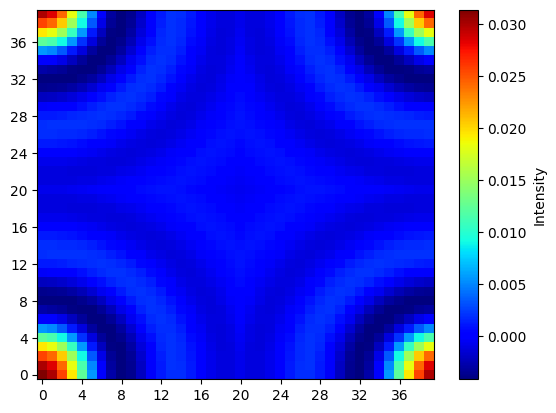

circle DC=(0.03141592815518379+0j), should be : 0.07853981695999998


In [40]:
c1 = circle(); c1.radius = to_dbu(1)
s1.data = c1

pattern.shapes.extend([s1])
pattern.parent.extend([-1])

fft_circle = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_circle)
print(f"circle DC={fft_circle[0]}, should be : {c1.area() * dbu * dbu/np.sqrt(len(fft_circle))}")

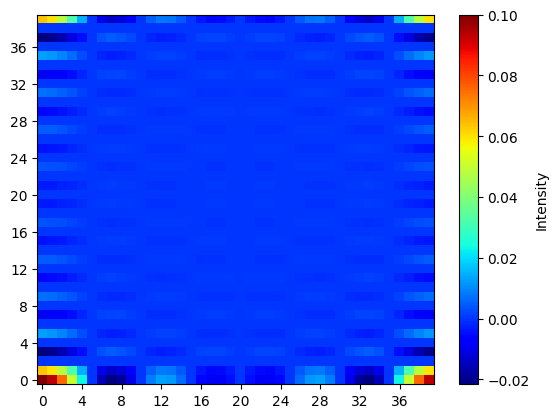

circle DC=(0.10000000149011612+0j), should be : 0.24999999569919998


In [41]:
c1 = rect(); c1.halfwidth = [to_dbu(1), to_dbu(pitch/4)]
s1.data = c1
pattern.shapes[:] = s1

fft_rect = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_rect)
print(f"circle DC={fft_rect[0]}, should be : {c1.area() * dbu * dbu/np.sqrt(len(fft_rect))}")

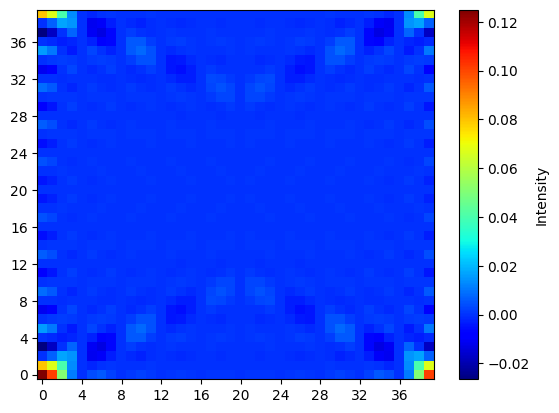

triangle DC=(0.125+0j)
circle DC=(0.125+0j), should be : 0.31250000117759996


In [42]:
c1 = poly(); c1.vertices.extend([[to_dbu(-2.5), to_dbu(-2.5)],[to_dbu(2.5), to_dbu(-2.5)],[0, to_dbu(2.5)]])
s1.data = c1

pattern.shapes[:] = s1

fft_tri = raster_pattern_fourier_transform(pattern, grid_info_2d)
grid_info_2d.display(fft_tri)
print(f"triangle DC={fft_tri[0]}")
print(f"circle DC={fft_tri[0]}, should be : {c1.area() * dbu * dbu/np.sqrt(len(fft_tri))}")

In [43]:
def get_raster(input):
    raster = xsize * ysize *np.fft.fftshift(np.fft.ifft2(np.array(input).reshape(*grid_info_2d.tilesize)).astype(np.complex64))
    return raster.flatten().tolist()

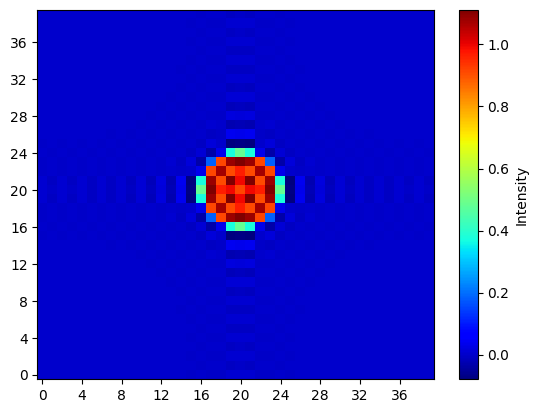

In [44]:
grid_info_2d.display(get_raster(fft_circle))

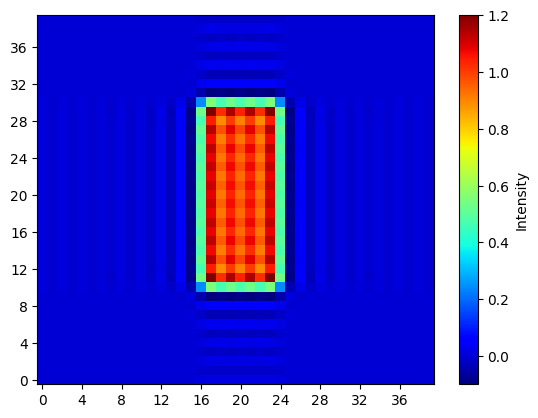

In [45]:
grid_info_2d.display(get_raster(fft_rect))

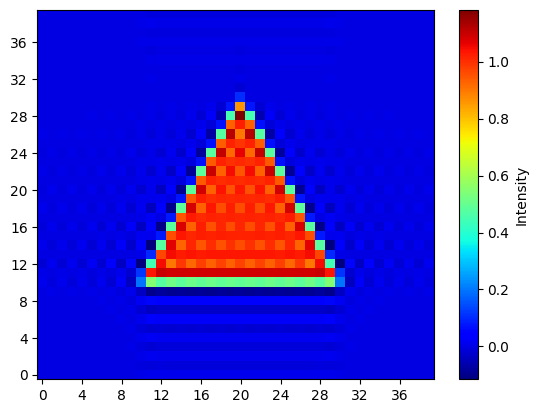

In [46]:
grid_info_2d.display(get_raster(fft_tri))

#### Laurent's Rule

In [47]:
import numpy as np


print(fft_circle[0])
print([[fft_circle[(ysize -1-i) * xsize], fft_circle[(1 + i) * xsize], fft_circle[xsize - 1 - i], fft_circle[i + 1]] for i in range(2)])

n = len(fft_circle)
N1 = xsize
N2 = ysize

# 1. 将展平的 fft_tri 还原为 2D 频谱矩阵
# 此时频谱中心（DC）通常在 [0,0]
spectrum_2d = np.array(fft_circle).reshape(N1, N2)

# 2. 构建 2D 卷积矩阵 (Convolution Matrix)
# 对于 2D RCWA，矩阵中的项 M_{pq, rs} = spectrum_2d[p-r, q-s]
# 索引处理需考虑周期性（循环卷积）
conv_matrix = np.zeros((n, n), dtype=complex)

for r in range(N1):
    for s in range(N2):
        row_idx = r * N2 + s
        for p in range(N1):
            for q in range(N2):
                col_idx = p * N2 + q
                # 计算频率差值，并处理 corner-zero 格式的索引
                # (p-r) 和 (q-s) 映射回 [0, N1) 和 [0, N2)
                conv_matrix[row_idx, col_idx] = spectrum_2d[(r - p) % N1, (s - q) % N2]

# 3. 求解逆矩阵
Y = np.identity(n)
# 使用 np.linalg.solve 而不是 inv，数值稳定性更好
x = np.linalg.solve(conv_matrix, Y)

(0.03141592815518379+0j)
[[(0.02989090606570244+0j), (0.02989090606570244+0j), (0.02989090606570244+0j), (0.02989090606570244+0j)], [(0.025609536096453667+0j), (0.025609536096453667+0j), (0.025609536096453667+0j), (0.025609536096453667+0j)]]


In [54]:
from scipy.linalg import toeplitz

def get_full_conv_matrix(kernel, input_size):
    """
    构造一个 (N*N, N*N) 的矩阵，实现 'same' 模式的卷积
    kernel: 二维卷积核 (kh, kw)
    input_size: 输入矩阵的边长 N
    """
    N = input_size
    kh, kw = kernel.shape
    
    # 为了保持 'same' 卷积，计算填充偏移量
    pad_h = kh // 2
    pad_w = kw // 2
    
    # 初始化巨大的方阵 (N^2, N^2)
    H = np.zeros((N * N, N * N))
    
    for i in range(N): # 行索引
        for j in range(N): # 列索引
            row_idx = i * N + j
            
            # 对卷积核的每一个元素进行映射
            for ki in range(kh):
                for kj in range(kw):
                    # 计算在原始输入中对应的位置
                    orig_i = i + ki - pad_h
                    orig_j = j + kj - pad_w
                    
                    # 检查是否在边界内 (Zero Padding 逻辑)
                    if 0 <= orig_i < N and 0 <= orig_j < N:
                        col_idx = orig_i * N + orig_j
                        # 注意：矩阵中的值通常是卷积核对应位置的翻转或直接映射
                        # 这里按标准互相关/卷积映射
                        H[row_idx, col_idx] = kernel[ki, kj]
    return H

# --- 示例演示 ---
N = 3
I = np.arange(1, 10).reshape(N, N)
# 定义一个简单的 3x3 锐化算子或恒等算子
K = np.array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 0]])

H_matrix = get_full_conv_matrix(K, N)

print(f"输入矩阵 I (3x3):\n{I}")
print(f"\n卷积矩阵 H 的形状: {H_matrix.shape}")
print(f"\n卷积矩阵 H (前几行):\n{H_matrix[:3, :9]}")

# 验证结果
x = I.flatten()
y = H_matrix @ x
print(f"\n矩阵乘法结果 (展平): {y}")
print(f"还原为 3x3:\n{y.reshape(N, N)}")


n2 = len(fft_circle)
print(n2, grid_info_2d.tilesize)
conv_matrix = get_full_conv_matrix(np.array(fft_circle).reshape(*grid_info_2d.tilesize), 40)
print(conv_matrix[0][0:5])

输入矩阵 I (3x3):
[[1 2 3]
 [4 5 6]
 [7 8 9]]

卷积矩阵 H 的形状: (9, 9)

卷积矩阵 H (前几行):
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]]

矩阵乘法结果 (展平): [1. 2. 3. 4. 5. 6. 7. 8. 9.]
还原为 3x3:
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
1600 [40,40]


/tmp/ipykernel_67861/1812084931.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  H[row_idx, col_idx] = kernel[ki, kj]


[-6.45024353e-04 -5.27353608e-04 -3.04184126e-04 -1.64426674e-05
  2.86292721e-04]


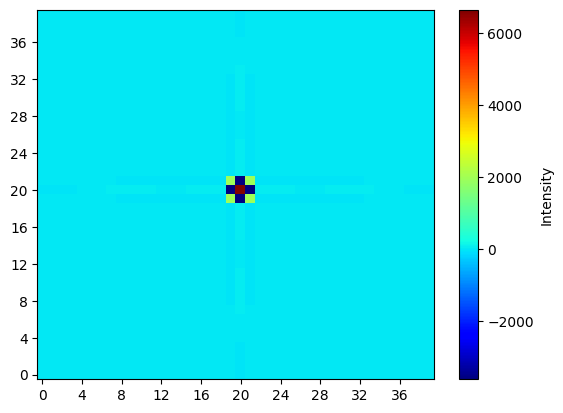

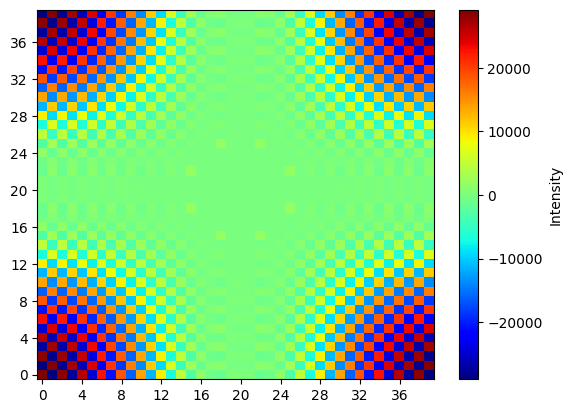

In [ ]:
grid_info_2d.display(x.flatten().tolist())
grid_info_2d.display(get_raster(x.flatten().tolist()[0:1600]))